In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


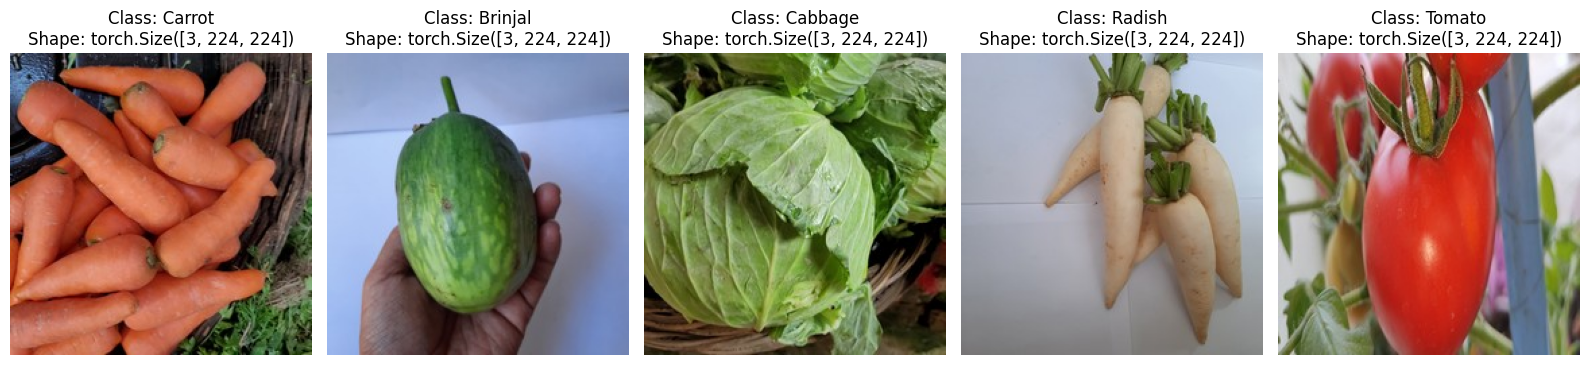

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from IPython.display import display, HTML

def plot_random_images(dataset, num_images=5):
    display(HTML('<H2 style="color:green"> <b>Data Visualization</b></H2><hr>'))

    plt.figure(figsize=(16, 4))
    for i in range(num_images):
        index = random.randint(0, len(dataset) - 1)
        image, label = dataset[index]

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Class: {dataset.classes[label]}\nShape: {image.shape}')
        plt.axis(False)

    plt.tight_layout()
    plt.show()
    display(HTML('<hr>'))

def main():
    # Define the directory containing the dataset
    TRAIN_DIR = '/content/drive/MyDrive/Vegetable Image Dataset/Vegetable Images/train'

    # Define transformations for image preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Load the dataset
    dataset = ImageFolder(root=TRAIN_DIR, transform=transform)

    # Plot random images from the dataset
    plot_random_images(dataset)

if __name__ == "__main__":
    main()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

# Constants
DATA_DIRECTORY = '/kaggle/input/vegetable-image-dataset/Vegetable Images'
BATCH_SIZE = 32
NUM_WORKERS = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations with more augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(30),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

def load_datasets():
    return {x: datasets.ImageFolder(os.path.join(DATA_DIRECTORY, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

def create_dataloaders(image_datasets):
    return {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'validation', 'test']}

def setup_model():
    model = models.vgg16(pretrained=True)  # Use pre-trained weights
    for param in model.parameters():
        param.requires_grad = False  # Freeze pre-trained layers
    num_output_classes = len(image_datasets['train'].classes)
    model.classifier[6] = nn.Sequential(
        nn.Linear(4096, 512),
        nn.ReLU(),
        nn.Dropout(0.5),  # Increased dropout
        nn.Linear(512, num_output_classes)  # Adding a new layer for classification
    )
    return model.to(device)

def train_model(model, criterion, optimizer, scheduler, num_epochs=20):  # Increased number of epochs
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc

    print('Best validation Acc: {:4f}'.format(best_acc))

# Usage
image_datasets = load_datasets()
dataloaders = create_dataloaders(image_datasets)
model = setup_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Reduced learning rate

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(model, criterion, optimizer, scheduler, num_epochs=10)  # Increased number of epochs


Epoch 1/10
----------
train Loss: 1.6984 Acc: 0.5331
validation Loss: 0.3301 Acc: 0.8947
Epoch 2/10
----------
train Loss: 1.5941 Acc: 0.5580
validation Loss: 0.5084 Acc: 0.8840
Epoch 3/10
----------
train Loss: 1.6407 Acc: 0.5444
validation Loss: 0.2537 Acc: 0.9320
Epoch 4/10
----------
train Loss: 1.5727 Acc: 0.5625
validation Loss: 0.3113 Acc: 0.9183
Epoch 5/10
----------
train Loss: 1.6225 Acc: 0.5512
validation Loss: 0.4060 Acc: 0.9193
Epoch 6/10
----------
train Loss: 1.6432 Acc: 0.5469
validation Loss: 0.4408 Acc: 0.9120
Epoch 7/10
----------
train Loss: 1.6309 Acc: 0.5437
validation Loss: 0.3214 Acc: 0.9183
Epoch 8/10
----------
train Loss: 1.4534 Acc: 0.5821
validation Loss: 0.2806 Acc: 0.9330
Epoch 9/10
----------
train Loss: 1.3157 Acc: 0.6143
validation Loss: 0.2427 Acc: 0.9473
Epoch 10/10
----------
train Loss: 1.2436 Acc: 0.6421
validation Loss: 0.2211 Acc: 0.9560
Best validation Acc: 0.956000


Test Accuracy: 0.9507
Precision: 0.9538
Recall: 0.9507
F1 Score: 0.9515
Mean Loss: 0.2448


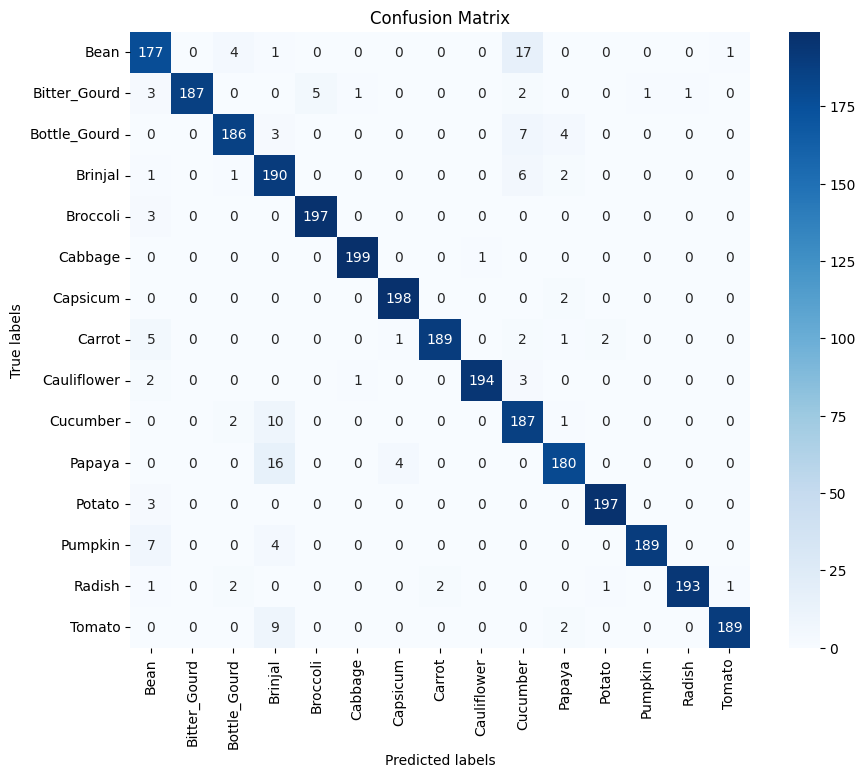

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mean_loss = np.mean(losses)

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Mean Loss: {mean_loss:.4f}')

    return y_true, y_pred

# Evaluate the model
y_true, y_pred = evaluate_model(model, dataloaders['test'])

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
class_names = image_datasets['test'].classes
plot_confusion_matrix(conf_matrix, class_names)
